# Recommendation Chatbot API: Evaluation llama2 vs llama3

In [1]:
%%capture output
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

BASE_PATH         = '../..'
API_PATH          = f'{BASE_PATH}/chat-bot-api'
LIB_PATH          = f'{BASE_PATH}/lib'
METRICS_PATH      = f'{BASE_PATH}/metrics'

sys.path.append(LIB_PATH)
sys.path.append(API_PATH)

In [70]:
import logging
import os
import pytorch_common.util as pu
import util as ut
from client import RecChatBotV1ApiClient
from models import EvaluationState
import seaborn as sns
import pandas as pd
from models.evaluation import (
    smooth_lineplot,
    plot_smooth_line,
    plot_ndcg_sessions,
    plot_n_users_by_session_evolution_size,
)
import matplotlib.pyplot as plt

## Helper functions

In [68]:
def plot_plot_mean_ndcg_evolutions(llama2_sessions, llama3_sessions):
    values_1 = list(llama2_sessions.steps_by_index.mean_ndcg.values())
    values_2 = list(llama3_sessions.steps_by_index.mean_ndcg.values())
    
    count = min(len(values_1), len(values_2))
    
    df = pd.DataFrame({
     'step': list(range(1, count+1)),
     'llama2': values_1[:count],
     'llama3': values_2[:count]
    })
    
    df['llama2'] = df['llama2'].rolling(window=15).mean()
    df['llama3'] = df['llama3'].rolling(window=15).mean()
    
    df = pd.melt(
        df, id_vars=['step'], 
        value_vars=['llama2', 'llama3'], 
        var_name='model', 
        value_name='mean_ndcg')
    
    sns.lineplot(
        data=df,
        x='step',
        y='mean_ndcg',
        hue='model'
    )
    
    plt.xlabel("User Session Step")
    plt.ylabel("NDGC")
    plt.title("NDGC by User Session Step")

## Setup

In [51]:
def on_file(file_path, format='%(asctime)s - %(levelname)s - %(message)s'):
    handler = logging.FileHandler(file_path)
    handler.setFormatter(logging.Formatter(format))
    return handler


pu.LoggerBuilder() \
    .handler(on_file('./evaluation.log'))\
    .on_console() \
    .build()

<RootLogger root (INFO)>

In [59]:
llama2_sessions = EvaluationState.load(f'{METRICS_PATH}/evaluation-metrics-llama2.dt').sessions
llama3_sessions = EvaluationState.load(f'{METRICS_PATH}/evaluation-metrics-llama3.dt').sessions

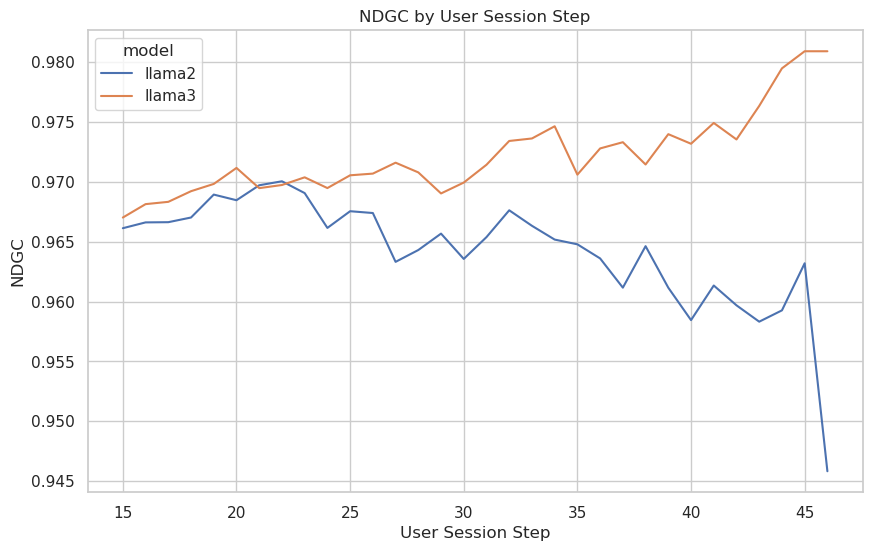

In [71]:
plot_plot_mean_ndcg_evolutions(llama2_sessions, llama3_sessions)